# Feature Map Analysis (Monochrome Data Type)

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import h5py
import numpy as np

import tensorflow as tf
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array
from keras.models import Model
import matplotlib.pyplot as plt
from cmcrameri import cm
from numpy import expand_dims

import sys
sys.path.append('./..')

from src.utils import get_cluster_labels, get_ds_iters
from src.training_utils import (
    data_load,
    split_dataset,
)
from src.plot_utils import get_plot_configs

2024-04-16 16:15:26.430617: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 16:15:26.456785: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 16:15:26.925737: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load Datasets

In [2]:
hf = h5py.File(f"../data/no-rolling/dataset_tumble_0.050_density_0.25.h5", "r")
iters = get_ds_iters(hf.keys())
img = hf[f"conf_{iters[300]}"]
img = np.array(img)
img[img>0]=1
img = img.reshape((img.shape[0], img.shape[1], 1))

hf = h5py.File(f"../data/no-rolling/dataset_tumble_0.157_density_0.25.h5", "r")
iters = get_ds_iters(hf.keys())
img2 = hf[f"conf_{iters[300]}"]
img2 = np.array(img2)
img2[img2>0]=1
img2 = img2.reshape((img2.shape[0], img2.shape[1], 1))

# Example Datamaps ($P_t \in \{ 0.050,0.157\}$, $\rho = 0.25$)

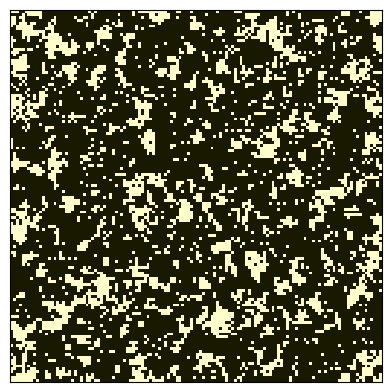

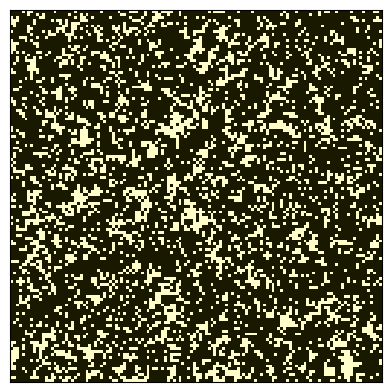

In [3]:
plt.matshow(img, cmap='cmc.lajolla')
plt.xticks([])
plt.yticks([])
plt.savefig('../plots/fmaps/input_0.050.svg', bbox_inches='tight', pad_inches=-0.1)
plt.matshow(img2, cmap='cmc.lajolla')
plt.xticks([])
plt.yticks([])
plt.savefig('../plots/fmaps/input_0.157.svg', bbox_inches='tight', pad_inches=-0.1)

# Set Up GPU and Load Model

Reminder: the following commands need to be ran in console in order to employ GPU. This is not strictly necessary here, since running on the CPU only affects performance (and we are computing very little data here). This is nonetheless a good habit.
```bash
export CUDNN_PATH=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))
export LD_LIBRARY_PATH=${CUDNN_PATH}/lib
export PATH=/usr/local/nvidia/bin:/usr/local/cuda/bin:$PATH
```


In [4]:
model = tf.keras.models.load_model('../models/monochrome0216.keras')

2024-04-16 16:15:29.155891: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 16:15:29.866598: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 16:15:29.866961: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Plot Feature Maps

The following shows output feature maps from each architecture layer (indicated in titles). Row 0 is low tumbling rate ($P_t=0.050$), row 1 is high tumbling rate ($P_t=0.157$). Multiple columns indicates multiple emergent feature maps (decided by number of filters) from however many input feature maps the layer takes (dictated by previous layer output maps).

In [5]:
def model_mapper (img,img2,model,layer_number,shift=None,ncols=3,post_avgpool=False,flattened=False,output=False,path=f"../plots/fmaps/"):
    model_mini = Model(inputs=model.inputs, outputs=model.layers[layer_number].output)

    feature_maps1 = model_mini.predict(img, verbose=0)
    feature_maps2 = model_mini.predict(img2, verbose=0)

    if post_avgpool == False and flattened == False:
        i = 2
        j = ncols
        for idx in range(i):
            for jdx in range(j):
                ax = plt.subplot(i, j, idx*j+jdx+1)
                ax.set_xticks([])
                ax.set_yticks([])
                if idx == 0:
                    plt.imshow(feature_maps1[:shift, :, 0, jdx], cmap='cmc.lajolla')
                else:
                    plt.imshow(feature_maps2[:shift, :, 0, jdx], cmap='cmc.lajolla')
        if output == True:
            plt.savefig(path+f"layer_{layer_number}.svg",bbox_inches='tight')

    if post_avgpool == True and flattened == False: #plots images which do not output multiple filters
        plt.matshow(feature_maps1[:, :],cmap='cmc.lajolla')
        plt.xticks([])
        plt.yticks([])
        if output == True:
            plt.savefig(path+f"layer_{layer_number}_im1.svg",bbox_inches='tight')
        plt.matshow(feature_maps2[:, :],cmap='cmc.lajolla')
        plt.xticks([])
        plt.yticks([])
        if output == True:
            plt.savefig(path+f"layer_{layer_number}_im2.svg",bbox_inches='tight')



    if post_avgpool == True and flattened == True: #rotates images which do not output multiple filters provided they are flattened (turns vertical to horizontal)
        plt.matshow(np.rot90(feature_maps1[:, :]),cmap='cmc.lajolla')
        plt.xticks([])
        plt.yticks([])
        if output == True:
            plt.savefig(path+f"layer_{layer_number}_im1.svg",bbox_inches='tight')
        plt.matshow(np.rot90(feature_maps2[:, :]),cmap='cmc.lajolla')
        plt.xticks([])
        plt.yticks([])
        if output == True:
            plt.savefig(path+f"layer_{layer_number}_im2.svg",bbox_inches='tight')


def kernel_printer(model,layer_number=0,path=f"../plots/fmaps/"):
    filters, biases = model.layers[layer_number].get_weights()
    print (filters.shape[-1])
    for k in range(filters.shape[-1]):
        f = filters[:, :, :, k]
        plt.matshow(f[:,:,0],cmap="cmc.lajolla")
        plt.xticks([])
        plt.yticks([])
        plt.savefig(path+f"kernel_{k}_layer_{layer_number}.svg",bbox_inches='tight')

### 1. CONV (filters=3,kernel_size=(3,3),padding='same',input_shape=shape)

I0000 00:00:1713280530.466361    8794 service.cc:145] XLA service 0x78dc1c002cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713280530.466396    8794 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-04-16 16:15:30.560875: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1713280531.625524    8794 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


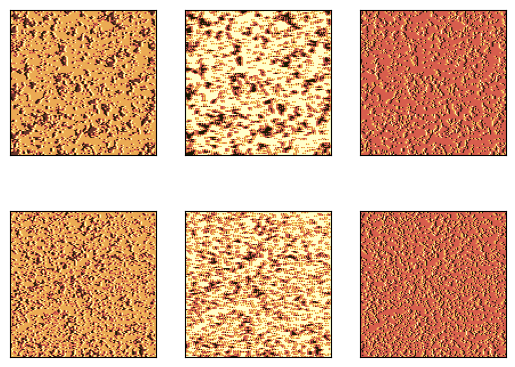

In [6]:
model_mapper (img,img2,model,shift=None,layer_number=0,output=True)

#### Computed with the Following Kernels

3


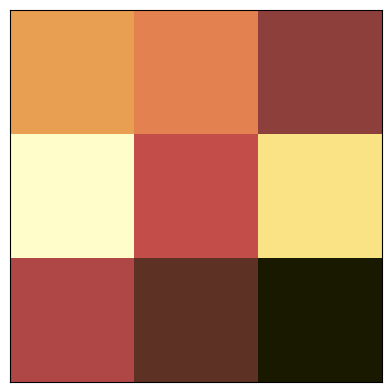

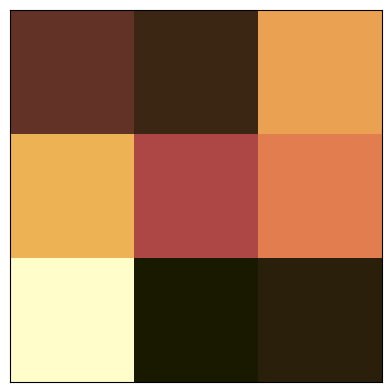

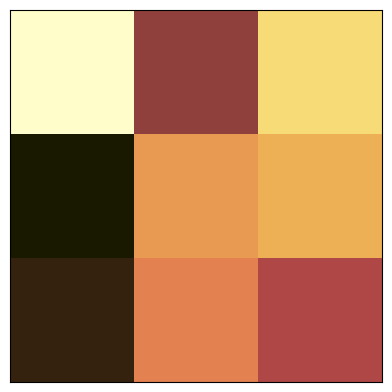

In [7]:
kernel_printer(model,layer_number=0,path=f"../plots/fmaps/")

### 2. MAXPOOL (pool_size=(2,2),padding='same')

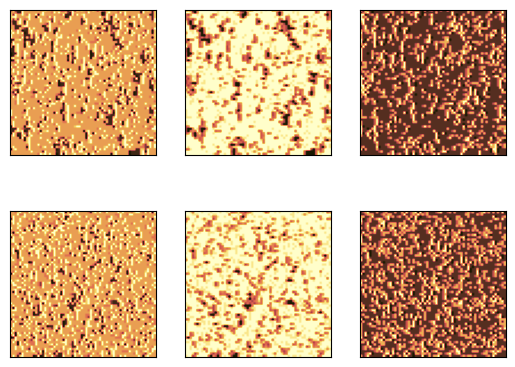

In [8]:
model_mapper (img,img2,model,shift=64,layer_number=1,output=True)

### 3. ReLU

2024-04-16 16:15:32.456222: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


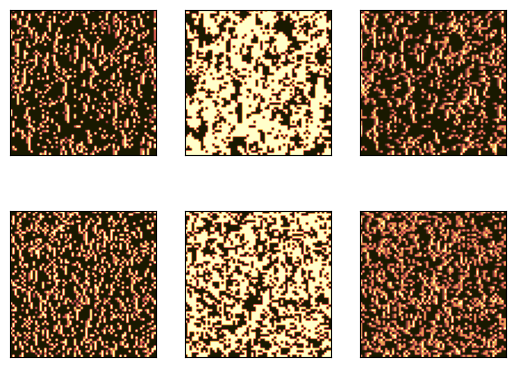

In [9]:
model_mapper (img,img2,model,shift=64,layer_number=2,output=True)

### 4. BN

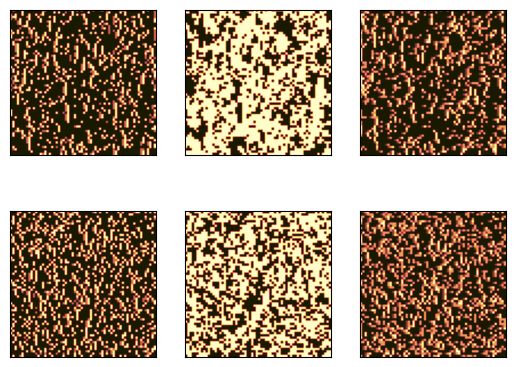

In [10]:
model_mapper (img,img2,model,shift=64,layer_number=3,output=False)

### 5. CONV (filters=4,kernel_size=(5,5),padding='same')

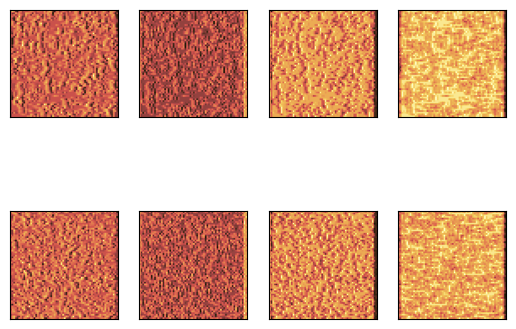

In [11]:
model_mapper (img,img2,model,shift=64,ncols=4,layer_number=4,output=True)

#### Computed with the Following Kernels

4


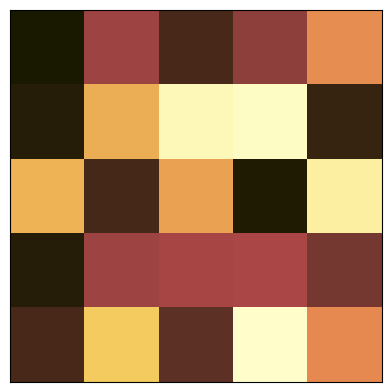

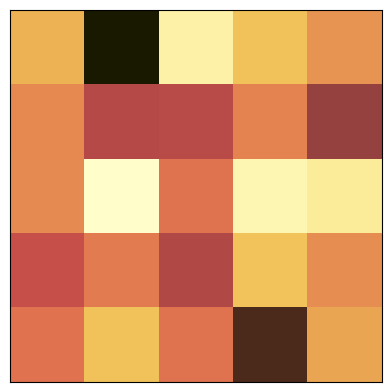

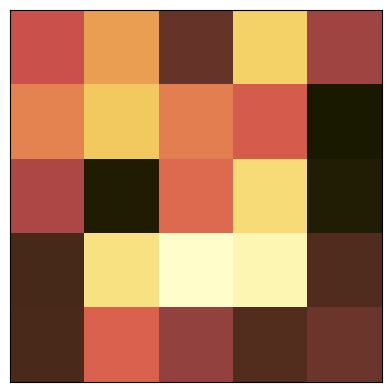

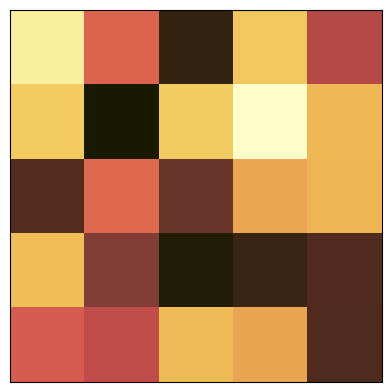

In [12]:
kernel_printer(model,layer_number=4,path=f"../plots/fmaps/")


### 6. MAXPOOL (pool_size=(2,2),padding='same')

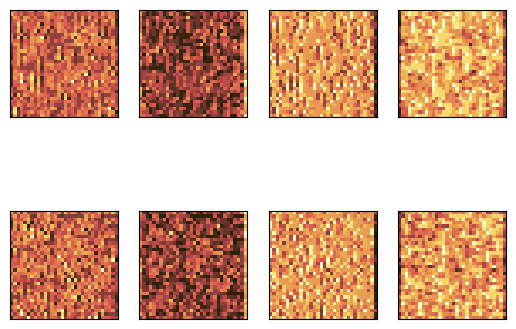

In [13]:
model_mapper (img,img2,model,shift=32,ncols=4,layer_number=5,output=True)

### 7. ReLU

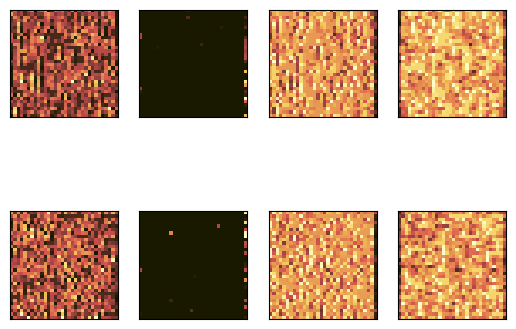

In [14]:
model_mapper (img,img2,model,shift=32,ncols=4,layer_number=6,output=True)

### 8. BN

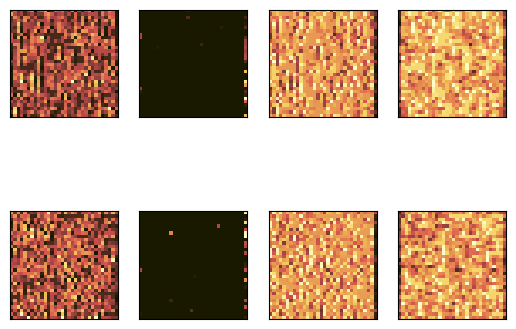

In [15]:
model_mapper (img,img2,model,shift=32,ncols=4,layer_number=7,output=False)

### 9. CONV (filters=6, kernel_size=(5,5),padding='same')

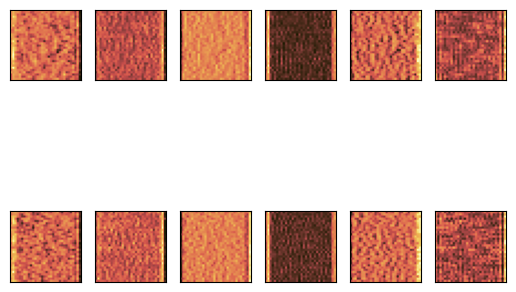

In [16]:
model_mapper (img,img2,model,shift=32,ncols=6,layer_number=8,output=True)

6


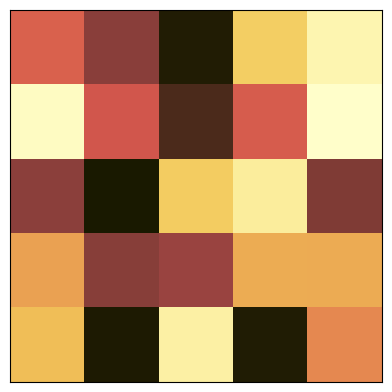

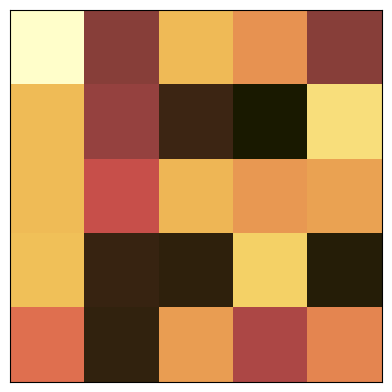

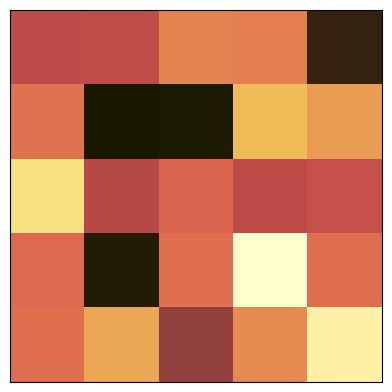

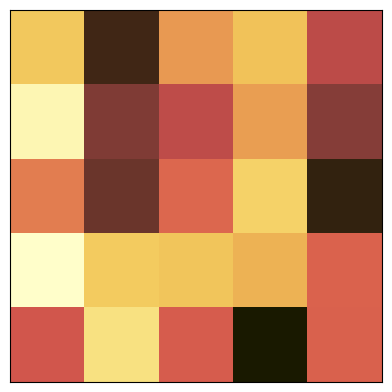

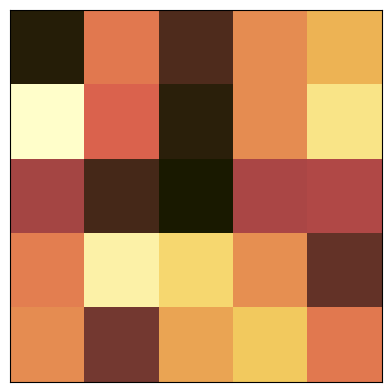

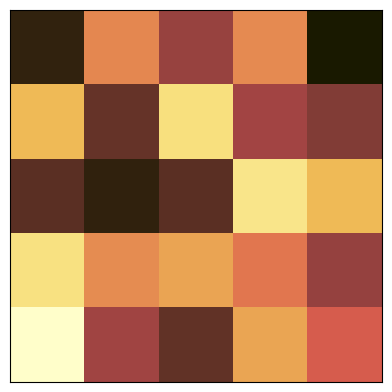

In [17]:
kernel_printer(model,layer_number=8,path=f"../plots/fmaps/")

### 10. MAXPOOL (pool_size=(2,2),padding='same')

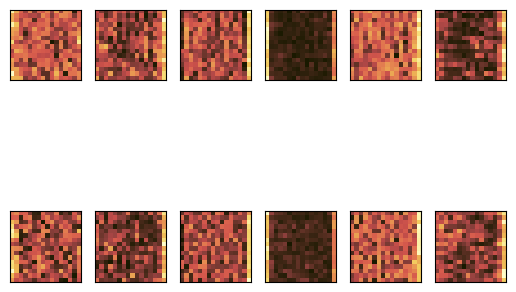

In [18]:
model_mapper (img,img2,model,shift=16,ncols=6,layer_number=9,output=True)

### 11. ReLU

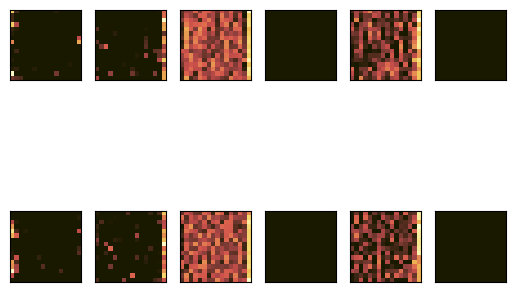

In [19]:
model_mapper (img,img2,model,shift=16,ncols=6,layer_number=10,output=True)

### 12. BN

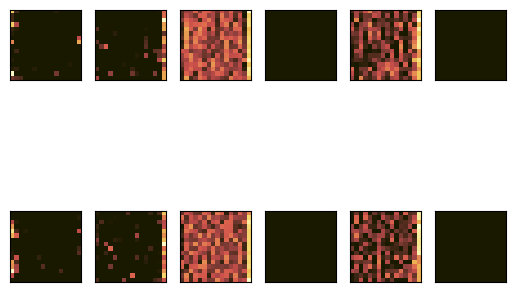

In [20]:
model_mapper (img,img2,model,shift=16,ncols=6,layer_number=11,output=False)

### 13. AVGPOOL

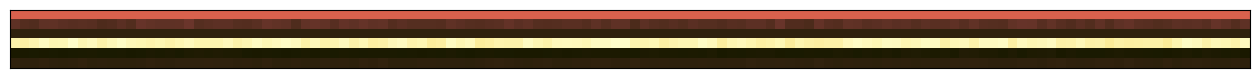

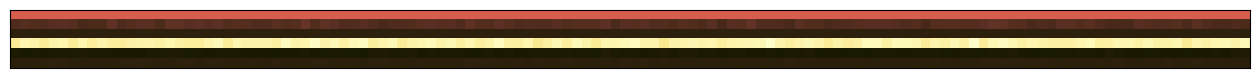

In [21]:
model_mapper (img,img2,model,layer_number=12,post_avgpool=True,flattened=True,output=True)


### 14. DO (0.1) (without layout optimiser)

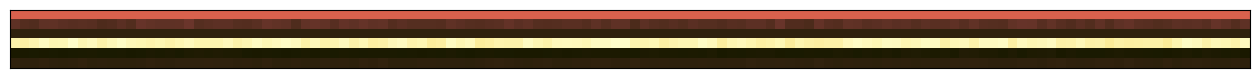

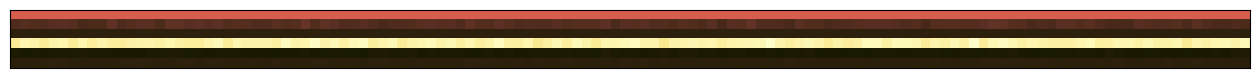

In [22]:
model_mapper (img,img2,model,layer_number=13,post_avgpool=True,flattened=True,output=False)

### 15. FC (units=128,activation='relu')

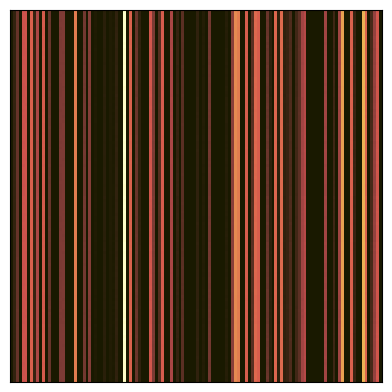

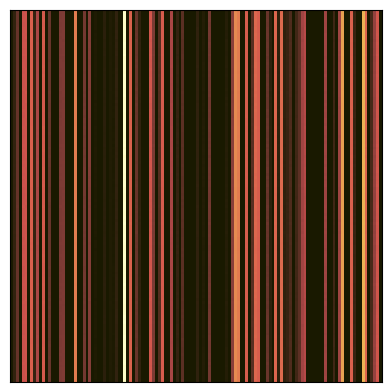

In [23]:
model_mapper (img,img2,model,layer_number=14,post_avgpool=True,flattened=False,output=True)

### 16. DO (0.1) (without layout optimiser)

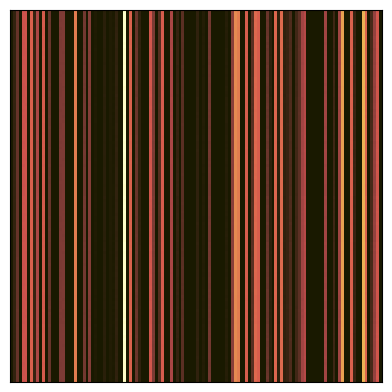

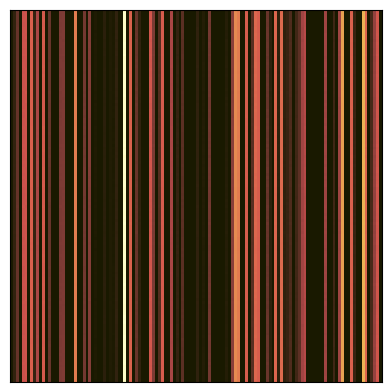

In [24]:
model_mapper (img,img2,model,layer_number=15,post_avgpool=True,flattened=False,output=False)

### 17. FC (units=3,activation='relu')

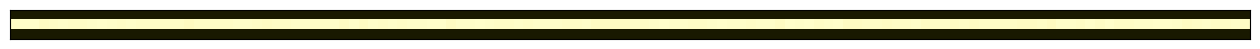

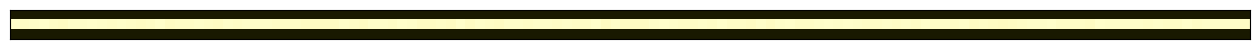

In [25]:
model_mapper (img,img2,model,layer_number=16,post_avgpool=True,flattened=True,output=True)

### 18. FLATTEN

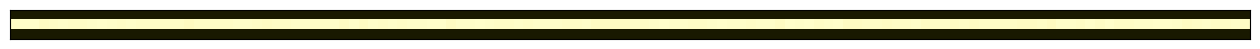

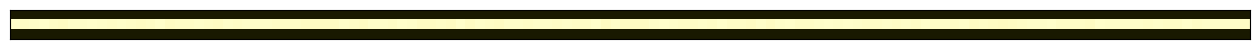

In [26]:
model_mapper (img,img2,model,layer_number=17,post_avgpool=True,flattened=True,output=False)

### 19. FC (units=1,activation='linear')

In [27]:
model_mapper (img,img2,model,layer_number=18,post_avgpool=True,flattened=True,output=True)

## Some notes

The batch normalisation layers do not display any change becase they simply renormalise the data. They are included here for completeness.

The dropout layers don't actually activate during model predictions. This is a deliberate feature of Keras which we've leveraged; the dropout layer helps with dataset training in order to prevent overfitting, but does not eliminate further data during actual prediction applications. They are also included here for completeness.